## Import packages and definitions

In [1]:
import re
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from pyathena import connect
from openai import OpenAI
import json
import math
from scipy.stats import zscore

%matplotlib inline
sns.set_theme()

In [2]:
def load_key_from_json(key_path, key_name):
    with open(key_path, encoding="utf-8") as f:
        keys = json.load(f)
    
        return keys[key_name]

In [3]:
def get_completion(message, model='gpt-3.5-turbo-0125', temperature=0, tools=None): # max_tokens
    response = client.chat.completions.create(
        model=model,
        messages=[
            {
                "role": "system",
                "content": "You are helpful assistant.",
            },
            {"role": "user", "content": message},
        ],
        temperature=temperature,
        # max_tokens=max_tokens,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0 # seed=1001
    )
    
    return response # response_format={ "type": "json_object"}, designed to output JSON

In [4]:
def list_of_word_len(x): # x is the series
    return [len(text.split()) for text in x.tolist()]

def avg_count(x): # x is the series of plaintext
     return sum(list_of_word_len(x))/len(x)

## Initialize openai gpt

In [5]:
KEY_PATH = "/home/ec2-user/SageMaker/important_keys.json"
# API key setting
os.environ["OPENAI_API_KEY"] = load_key_from_json(KEY_PATH, "OPENAI_API_KEY")
# Clients setting
client = OpenAI()

## Import data

In [6]:
conn = connect(
    s3_staging_dir='s3://trepp-developmentservices-lake-athena/ds/',
    region_name='us-east-1')

In [7]:
SQL = """
SELECT *
FROM "presentation_dev"."treppwirecreditstories" 
WHERE 
    authorname IS NOT NULL
    and
    authorname != ' '
    and 
    SUBSTR(publishdate, 1, 4) >= '2019';
"""

tpwire = pd.read_sql(SQL, conn)

/tmp/ipykernel_27658/241679148.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  tpwire = pd.read_sql(SQL, conn)


In [8]:
print(tpwire.summaryplaintext[0])

Follow-up: Lucky’s Market Bankruptcy Update – Publix to Acquire Some LocationsEarlier this week, we noted that Lucky’s Market had filed for bankruptcy and will be closing the majority of its stores.We pointed out that two CMBS loans that investors would want to footnote, one of which includes the $550,963 Food Lion – Ormond Beach, FL. The loan makes up 6.7% of the remaining collateral behind WBCMT 2004-C12. Lucky’s occupies 100% of the 26,640-square-foot single-tenant property backing the loan.According to news reports, the lease at the store behind the loan will be purchased by Publix.


In [9]:
tpwire['publishdate'] = pd.to_datetime(tpwire['publishdate'])

## Identify table's missing values

In [13]:
def print_missing_value_tb(df):
    missing_counts = (df == '[]').sum().sort_values()
    missing_percent = round(missing_counts * 100 / len(df),1)
    columns = list(missing_counts.index)
    
    return pd.DataFrame({"Columns": columns, "Counts": list(missing_counts), "Percentage(%)": list(missing_percent)})

In [14]:
miss_tb = print_missing_value_tb(tpwire)

Text(0, 0.5, 'Missing counts')

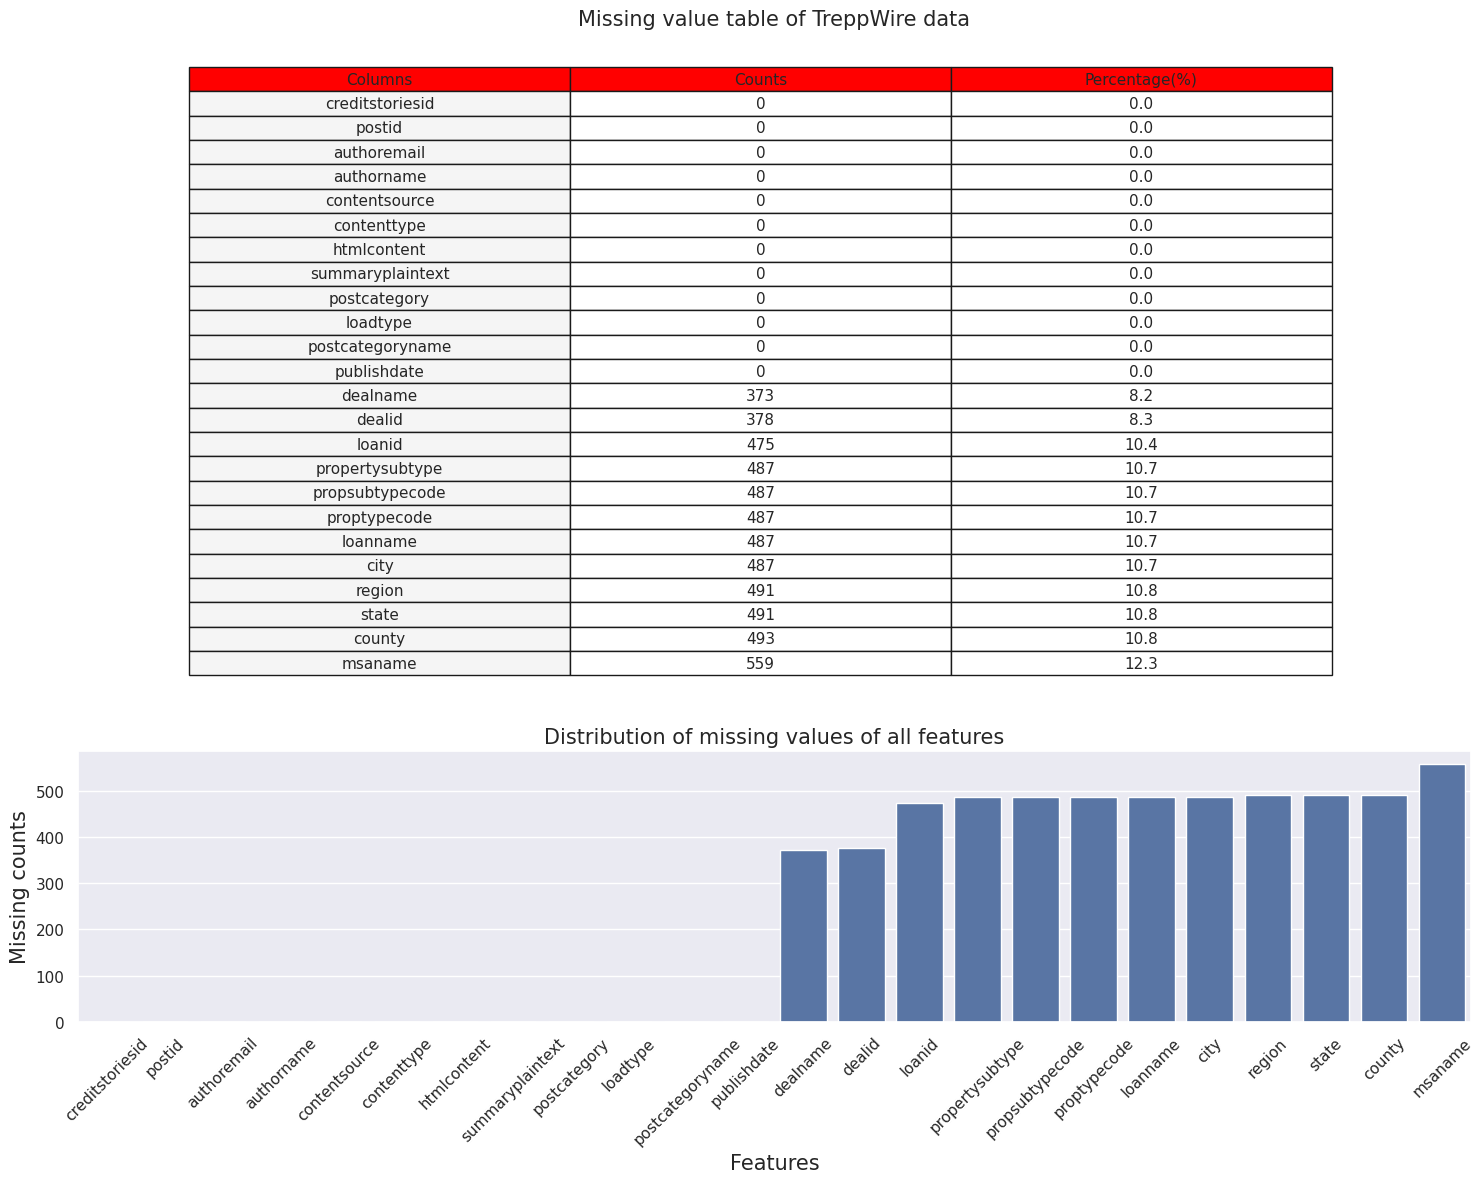

In [15]:
fig, (ax1, ax2) = plt.subplots(nrows=2, 
                               figsize=(15,12),
                               gridspec_kw={'height_ratios':[10,4]},
                               tight_layout=True)

ax1.set_axis_off() 
table = ax1.table(
    cellText=miss_tb.to_numpy(),
    cellLoc='center',
    cellColours=[['whitesmoke', 'white', 'white']]*len(miss_tb),
    colLabels=miss_tb.columns,
    colColours=['red']*3,
    loc='center',
    bbox=[0.08, 0.05, 0.82, 0.9])
table.set_fontsize(11)
ax1.set_title(f'Missing value table of TreppWire data', fontsize=15)


sns.barplot(
    data=miss_tb, 
    x='Columns', y='Counts',
    ax=ax2)
ax2.tick_params(axis='x',rotation=45)
ax2.set_title('Distribution of missing values of all features', fontsize=15)
ax2.set_xlabel('Features', fontsize=15)
ax2.set_ylabel('Missing counts', fontsize=15)

Missing value are shown above.

## Data Exploration

In [13]:
tpwire

,creditstoriesid,postid,authoremail,authorname,contentsource,contenttype,dealname,htmlcontent,summaryplaintext,loanid,...,propertysubtype,propsubtypecode,proptypecode,state,county,city,msaname,loanname,region,publishdate
0,02abd2df0ae0b47d49c9595b1f63803ce7fd863af680ba...,53833,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[JPMCC 2010-C2],<h4><strong>Follow-up: Lucky’s Market Bankrupt...,Follow-up: Lucky’s Market Bankruptcy Update – ...,[278029],...,[Urban Office],[Office],[OF],[TX],[Dallas],[Dallas],"[Dallas-Fort Worth-Arlington, TX]",[Bryan Tower],[West South Central],2020-02-05 08:49:56
1,b06de2f945ac8d29a6ed4b612f24a4389c5c1dfe945cdd...,52731,mclancy@trepp.com,Manus Clancy,TreppWire,post,[WABR 2016-BOCA],"<h4><span style=""color: #000000;""><strong>Larg...",Large South Florida Lodging Resort Trades Hand...,[386366],...,[Full Service],[Hotel],[LO],[FL],[Palm Beach],[Boca Raton],"[Miami-Fort Lauderdale-West Palm Beach, FL]",[Waldorf Astoria Boca Raton Resort & Club],[South Atlantic],2019-04-29 08:49:51
2,5a7de7e54da69ff1e7c466a47d959dd78e0266b4cb8d2d...,53739,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[BANK 2018-BN10],<ul>\n<li>Industrial delinquency rate: Down th...,Industrial delinquency rate: Down three basis...,[418595],...,[Urban Office],[Office],[OF],[NJ],[Essex],[Newark],"[New York-Newark-Jersey City, NY-NJ-PA]",[One Newark Center],[Middle Atlantic],2020-01-02 10:20:41
3,032d3d15dc36994290b74a2d40156cbaf061823995f57e...,54312,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[GSMS 2015-GC34],<h4><strong>Texas Hotel Portfolio Unlikely to ...,Texas Hotel Portfolio Unlikely to Be Paid Off ...,[359219],...,[Garden / Low-Rise],[Multifamily],[MF],[NC],"[Cabarrus, Randolph, Various]","[High Point, Concord, Various, Kannapolis]","[Greensboro-High Point, NC, Charlotte-Concord-...","[Threshold Multifamily Portfolio - Pool 1, McL...",[South Atlantic],2020-10-07 09:22:03
4,14427cb10b9784a45bb56b113786accb92c96202b0361e...,55002,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[BXMT 2020-FL2],"<h4><strong>After Long Wait, Retailer Confirms...","After Long Wait, Retailer Confirms Plan to Vac...",[489884],...,[Urban Office],[Office],[OF],[IL],[Cook],[Chicago],"[Chicago-Naperville-Elgin, IL-IN-WI]",[Old Post Office],[East North Central],2021-08-27 07:53:11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4543,949bdc7c970771e2fedae6150c003be248be0e653fab16...,55759,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[CGCMT 2016-P5],<h4><strong>Trading Alert: Biggest Tenant Behi...,Trading Alert: Biggest Tenant Behind 2016 Offi...,[390426],...,[Urban Office],[Office],[OF],[FL],[Miami-Dade],[Miami],"[Miami-Fort Lauderdale-West Palm Beach, FL]",[Flagler Corporate Center],[South Atlantic],2022-09-23 09:12:00
4544,b5b94091cc7d2a2a906ce3b0da7db2d90fb22123281cd1...,54246,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[COMM 2015-LC23],<h4><strong>Florida Apartments Behind 2018 Age...,Florida Apartments Behind 2018 Agency Loan Sol...,[389541],...,"[Extended Stay, Limited Service]",[Hospitality],[LO],"[GA, TX, NC, CT, IN, NM, CA, IL, FL, WA, KY, T...","[Ingham, Sandoval, Columbia, Marion, DuPage, O...","[Austin, Asheville, Milford, Indianapolis, Orl...","[Louisville/Jefferson County, KY-IN, Jacksonvi...","[Hampton Inn College Station, Courtyard Carlsb...","[Mountain, New England, East North Central, We...",2020-08-27 09:18:17
4545,9cf3aed9d2444bb60aece2aa2cb988ecd00ea34c5813d4...,55992,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[CGCMT 2017-P8],<h4><strong>Trading Alert: Top Tenant Behind M...,Trading Alert: Top Tenant Behind Michigan Offi...,[408520],...,[Suburban Office],[Office],[OF],[MI],[Oakland],[Troy],"[Detroit-Warren-Dearborn, MI]",[Bank of America Plaza],[East North Central],2022-12-22 06:30:57
4546,66da7949c7bf622aa9bea47614c7b3f18a970445e2f344...,55233,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[UBSCM 2017-C7],<h4><strong>Apartment Complex in Fort Lauderda...,Apartment Complex 

### 1. Learn about primary keys

In [14]:
tpwire.publishdate[2]

Timestamp('2020-01-02 10:20:41')

In [15]:
tpwire.summaryplaintext[2]

' Industrial delinquency rate: Down three basis points Lodging delinquency rate: Up 22 basis points Multifamily delinquency rate: Up 39 basis points Office delinquency rate: Up 16 basis points Retail delinquency rate: Up 76 basis points Property Type Analysis CMBS 1.0:For December 2019'

In [16]:
tpwire['contenttype'].value_counts()
tpwire['contentsource'].value_counts()

contentsource
TreppWire    4548
Name: count, dtype: int64

In [17]:
tpwire[tpwire['postid'] == 33046].head()

,creditstoriesid,postid,authoremail,authorname,contentsource,contenttype,dealname,htmlcontent,summaryplaintext,loanid,...,propertysubtype,propsubtypecode,proptypecode,state,county,city,msaname,loanname,region,publishdate


This indicates for the same podcast, it may have different contents. Therefore, we have multiple records for each postid.

But for each postid, we have the unique loanid, propertysubtype, propertysubtypecode, propertycode

In [18]:
tpwire.duplicated(subset=['postid', 'summaryplaintext']).sum()

0

In [19]:
tpwire.duplicated(subset=['creditstoriesid']).sum()

11

In [20]:
tpwire[tpwire.duplicated(subset=['creditstoriesid'])].creditstoriesid.values[0]

'8d857f0d4ae32f1467d3aeb620827a5bcb791d955abefbfe5c2b8b1155c9f1ed'

In [21]:
tpwire[tpwire['creditstoriesid'] == '8d857f0d4ae32f1467d3aeb620827a5bcb791d955abefbfe5c2b8b1155c9f1ed']

,creditstoriesid,postid,authoremail,authorname,contentsource,contenttype,dealname,htmlcontent,summaryplaintext,loanid,...,propertysubtype,propsubtypecode,proptypecode,state,county,city,msaname,loanname,region,publishdate
338,8d857f0d4ae32f1467d3aeb620827a5bcb791d955abefb...,56301,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[],<h4> </h4>,,[],...,[],[],[],[],[],[],[],[],[],2023-06-01 06:30:24
952,8d857f0d4ae32f1467d3aeb620827a5bcb791d955abefb...,55817,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[],<h4> </h4>,,[],...,[],[],[],[],[],[],[],[],[],2022-10-14 09:57:13
1505,8d857f0d4ae32f1467d3aeb620827a5bcb791d955abefb...,56317,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[],<h4> </h4>,,[],...,[],[],[],[],[],[],[],[],[],2023-06-11 23:33:18
1925,8d857f0d4ae32f1467d3aeb620827a5bcb791d955abefb...,56278,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[],<h4> </h4>,,[],...,[],[],[],[],[],[],[],[],[],2023-05-16 06:30:23
2120,8d857f0d4ae32f1467d3aeb620827a5bcb791d955abefb...,56297,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[],<h4> </h4>,,[],...,[],[],[],[],[],[],[],[],[],2023-05-26 06:30:27
2370,8d857f0d4ae32f1467d3aeb620827a5bcb791d955abefb...,53427,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[],<h4> </h4>,,[],...,[],[],[],[],[],[],[],[],[],2019-09-06 09:16:11
3205,8d857f0d4ae32f1467d3aeb620827a5bcb791d955abefb...,55909,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[],<h4> </h4>,,[],...,[],[],[],[],[],[],[],[],[],2022-11-16 09:06:31
3434,8d857f0d4ae32f1467d3aeb620827a5bcb791d955abefb...,55942,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[],<h4> </h4>,,[],...,[],[],[],[],[],[],[],[],[],2022-12-01 09:10:52
3451,8d857f0d4ae32f1467d3aeb620827a5bcb791d955abefb...,56159,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[],<h4> </h4>,,[],...,[],[],[],[],[],[],[],[],[],2023-03-20 06:30:32
3858,8d857f0d4ae32f1467d3aeb620827a5bcb791d955abefb...,56041,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[],<h4> </h4>,,[],...,[],[],[],[],[],[],[],[],[],2023-01-23 06:29:43


In [22]:
tpwire[tpwire['creditstoriesid'] == tpwire[tpwire.duplicated(subset=['creditstoriesid'])].values[10][0]]

,creditstoriesid,postid,authoremail,authorname,contentsource,contenttype,dealname,htmlcontent,summaryplaintext,loanid,...,propertysubtype,propsubtypecode,proptypecode,state,county,city,msaname,loanname,region,publishdate
338,8d857f0d4ae32f1467d3aeb620827a5bcb791d955abefb...,56301,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[],<h4> </h4>,,[],...,[],[],[],[],[],[],[],[],[],2023-06-01 06:30:24
952,8d857f0d4ae32f1467d3aeb620827a5bcb791d955abefb...,55817,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[],<h4> </h4>,,[],...,[],[],[],[],[],[],[],[],[],2022-10-14 09:57:13
1505,8d857f0d4ae32f1467d3aeb620827a5bcb791d955abefb...,56317,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[],<h4> </h4>,,[],...,[],[],[],[],[],[],[],[],[],2023-06-11 23:33:18
1925,8d857f0d4ae32f1467d3aeb620827a5bcb791d955abefb...,56278,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[],<h4> </h4>,,[],...,[],[],[],[],[],[],[],[],[],2023-05-16 06:30:23
2120,8d857f0d4ae32f1467d3aeb620827a5bcb791d955abefb...,56297,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[],<h4> </h4>,,[],...,[],[],[],[],[],[],[],[],[],2023-05-26 06:30:27
2370,8d857f0d4ae32f1467d3aeb620827a5bcb791d955abefb...,53427,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[],<h4> </h4>,,[],...,[],[],[],[],[],[],[],[],[],2019-09-06 09:16:11
3205,8d857f0d4ae32f1467d3aeb620827a5bcb791d955abefb...,55909,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[],<h4> </h4>,,[],...,[],[],[],[],[],[],[],[],[],2022-11-16 09:06:31
3434,8d857f0d4ae32f1467d3aeb620827a5bcb791d955abefb...,55942,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[],<h4> </h4>,,[],...,[],[],[],[],[],[],[],[],[],2022-12-01 09:10:52
3451,8d857f0d4ae32f1467d3aeb620827a5bcb791d955abefb...,56159,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[],<h4> </h4>,,[],...,[],[],[],[],[],[],[],[],[],2023-03-20 06:30:32
3858,8d857f0d4ae32f1467d3aeb620827a5bcb791d955abefb...,56041,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[],<h4> </h4>,,[],...,[],[],[],[],[],[],[],[],[],2023-01-23 06:29:43


I found there's something wrong when we have **creditstoriesid**, the content is empty. (0,1,3-10, except 2).

I think we need to those credit stories in data.

### 2. Text Exploration

#### 2.1 Number / Average length  of Credit storieswritten by authors

In [23]:
df_auth_story = tpwire['authorname'].value_counts().reset_index().sort_values(by='count', ascending=False)

In [24]:
df_avg_words = tpwire.groupby('authorname').agg(
    avg_word_count = ('summaryplaintext', lambda x: avg_count(x))
).reset_index().sort_values(by='avg_word_count')
df_avg_words

,authorname,avg_word_count
1,Hayley Keen,177.952045
3,Manus Clancy,190.005013
0,Dylan Wall,191.750000
2,Keegan St. Onge-May,308.400000


Text(0.5, 0, 'Author')

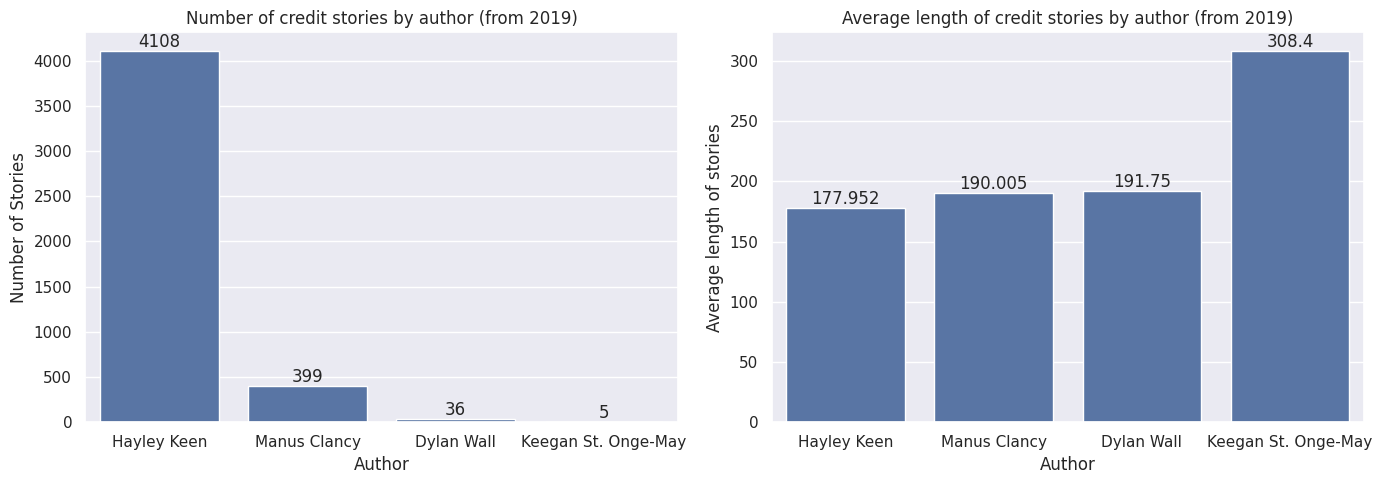

In [25]:
fig, ax = plt.subplots(1, 2, 
                       figsize=(7*2,5), 
                       tight_layout=True)
ax = ax.flatten()
g = sns.barplot(df_auth_story, 
            x='authorname', y='count',
           ax=ax[0])

for i in g.containers:
    ax[0].bar_label(i,)
    
ax[0].set_title('Number of credit stories by author (from 2019)')
ax[0].set_ylabel('Number of Stories')
ax[0].set_xlabel('Author')


g = sns.barplot(df_avg_words, 
            x='authorname', y='avg_word_count',
           ax=ax[1])

for i in g.containers:
    ax[1].bar_label(i,)
    
ax[1].set_title('Average length of credit stories by author (from 2019)')
ax[1].set_ylabel('Average length of stories')
ax[1].set_xlabel('Author')

In [79]:
df_len = pd.DataFrame({'num_of_words': list_of_word_len(tpwire['summaryplaintext'])})
q1, q2, q3 = np.percentile(df_len, 25), np.median(df_len), np.percentile(df_len, 75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

df_len['is_outliers'] = (df_len['num_of_words'] < lower_bound) | (df_len['num_of_words'] > upper_bound)
outliers = df_len[df_len['is_outliers']]
outliers

,num_of_words,is_outliers
5,382,True
6,650,True
60,366,True
61,362,True
81,540,True
...,...,...
4461,638,True
4480,540,True
4498,422,True
4517,785,True


Text(0, 0.5, 'TreppWire Stories')

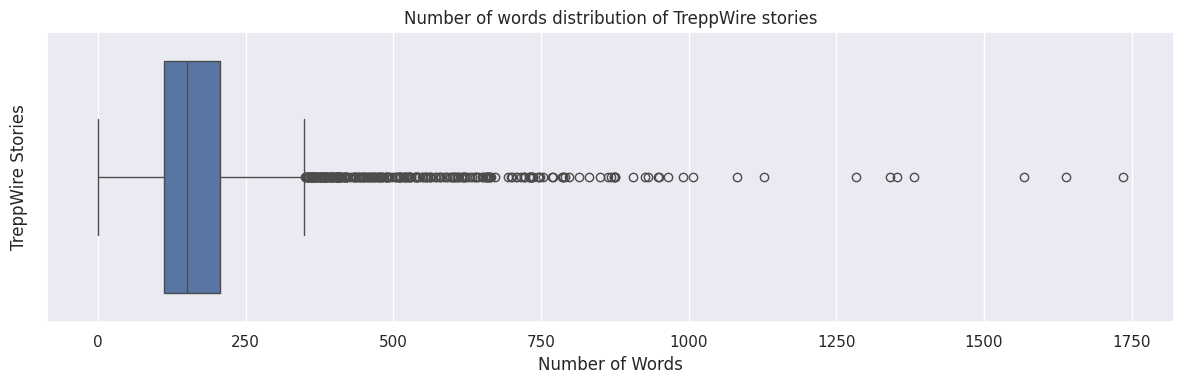

In [85]:
fig, ax = plt.subplots(1, 1, 
                      figsize=(12, 4),
                      tight_layout=True)
sns.boxplot(x=df_len['num_of_words'])
ax.set_title('Number of words distribution of TreppWire stories')
ax.set_xlabel('Number of Words')
ax.set_ylabel('TreppWire Stories')

In [84]:
# tpwire.iloc[outliers.index,:].summaryplaintext.values[10]
tpwire.iloc[outliers.index,:]

,creditstoriesid,postid,authoremail,authorname,contentsource,contenttype,dealname,htmlcontent,summaryplaintext,loanid,...,propertysubtype,propsubtypecode,proptypecode,state,county,city,msaname,loanname,region,publishdate
5,db3dad2a14c0a763be959e99093cc3c74990bdff54fc85...,56548,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[JPMCC 2012-LC9],<h4>Trading Alert: Philly Office Loan Extended...,Trading Alert: Philly Office Loan Extended(Edi...,[309787],...,[Government Office],[Office],[OF],[NJ],[Mercer],[Trenton],"[Trenton, NJ]","[50 East State Street, 33 West State Street]",[Middle Atlantic],2023-10-02 06:30:30
6,82ee53e9f31351f552b05bbba899477dc879750beb9f6c...,53685,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[DBUBS 2011-LC2A],"<table width=""550"">\n<tbody>\n<tr>\n<td width=...",Date Loan Count Loan Balance Realized Losse...,[210435],...,"[Suburban Office, Government Office]",[Office],[OF],[VA],[Fairfax],[Falls Church],"[Washington-Arlington-Alexandria, DC-VA-MD-WV]","[Two Skyline Place, Seven Skyline Place, One S...",[South Atlantic],2019-12-12 09:38:10
60,c1a02654c68029d9c6209bb7007f5f18db11ec307156ba...,52851,mclancy@trepp.com,Manus Clancy,TreppWire,post,[JPMCC 2006-LDP9],"<h4><span style=""color: #000000;""><strong>Ariz...",Arizona Community Shopping Center Behind 2015 ...,[206876],...,[Community Shopping Center],[Retail],[RT],[NV],[Clark],[Las Vegas],"[Las Vegas-Henderson-Paradise, NV]",[Kimco PNP - Rainbow Promenade],[Mountain],2019-05-06 10:02:51
61,20f06058dae0953fc051e885dd21ce367a986518c5ce98...,55331,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[MSC 2011-C1],<h4><strong>Trading Alert: New Times Square Ho...,Trading Alert: New Times Square Hotel REO Valu...,[281687],...,[Full Service],[Hospitality],[LO],[NY],[New York],[New York],"[New York-Newark-Jersey City, NY-NJ-PA]",[Hilton Times Square],[Middle Atlantic],2022-02-22 04:37:46
81,05e948321b760f31d11dfc07387e269bf487039b5e51ea...,53693,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[WBCMT 2007-C30],<h4><strong>More on November Losses</strong></...,More on November LossesRemittance data indicat...,[421772],...,[Flex / R&D],[Industrial],[IN],[CA],[Santa Clara],[San Jose],"[San Jose-Sunnyvale-Santa Clara, CA]",[3200 North First Street],[Pacific],2019-12-13 10:19:59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4461,a002488f28fc5f4ba00682c6d3a10c8c1df0960e33f4c6...,54547,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[LNCR 2018-CRE1],<h4><strong>January Loss Analysis: Suburban Of...,January Loss Analysis: Suburban Office Resolut...,[372640],...,[Urban Office],[Office],[OF],[NY],[New York],[New York],"[New York-Newark-Jersey City, NY-NJ-PA]",[11 Madison Avenue],[Middle Atlantic],2021-02-04 05:47:08
4480,43c7600e7e21c201931e36b9adf82f417678fa7f134e75...,56744,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[JPMCC 2012-LC9],"<h4><span style=""color: #000000;""><strong>Trad...",Trading Alert: Philly Office Loan Extension Te...,[447458],...,[Urban Office],[Office],[OF],[NY],[New York],[New York],"[New York-Newark-Jersey City, NY-NJ-PA]",[29 West 35th Street],[Middle Atlantic],2023-11-24 06:30:02
4498,cb494d2848a9d76f035d3867a1e71b3fc1f532ea6082d9...,56016,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[GSMS 2017-GS7],<h4><strong>December 2022 Payoff Report</stron...,December 2022 Payoff ReportThe percentage of l...,[418902],...,[Mixed Use],[Mixed Use],[MU],[NY],[New York],[New York],"[New York-Newark-Jersey City, NY-NJ-PA]",[90 Fifth Avenue],[Middle Atlantic],2023-01-09 06:35:38
4517,66b02b2fbb72061f6c70ebf31b1c56a0ce739209bb53e9...,55214,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[BCORE 2019-CORE],"<div id=""content"">\n<div id=""post-45954"">\n<di...",Ring HQ Behind 2021 Deal Sells The Rin...,[440017],...,"[Mixed Use, Flex / R&D, Urban Office]","[Mixed Use, Office]","[MU, OF]","[PA, NY, MD, VA]","[Kings, Baltimore City, Richmond City, New Yor...","[Pittsburgh, Baltimore, Richmond, New York, Br...","[Baltimor

In [30]:
# tpwire.iloc[outliers.index,:].summaryplaintext.values[10]

In [31]:
# print(tpwire.iloc[outliers.index,:].summaryplaintext.values[10])

In [32]:
tpwire.summaryplaintext.values[1]

'Follow-up: Lucky’s Market Bankruptcy Update – Publix to Acquire Some LocationsEarlier this week, we noted that Lucky’s Market had filed for bankruptcy and will be closing the majority of its stores.We pointed out that two CMBS loans that investors would want to footnote, one of which includes the $550,963 Food Lion – Ormond Beach, FL. The loan makes up 6.7% of the remaining collateral behind WBCMT 2004-C12. Lucky’s occupies 100% of the 26,640-square-foot single-tenant property backing the loan.According to news reports, the lease at the store behind the loan will be purchased by Publix.'

In [104]:
# tpwire.sort_values(by='publishdate').iloc[-1].loc['summaryplaintext']
tpwire.iloc[outliers.index,:].sort_values(by='publishdate').iloc[-198].loc['summaryplaintext']

' PennyMac Lays Off Roseville Staff According to the Sacramento Business Journal, PennyMac has announced that it will be permanently laying off employees at its office in Roseville. The article notes that the nationwide mortgage lender’s decision comes as a result of rising interest rates. For the moment, CMBS investors may want to footnote the $25.5 million Olympus Corporate Center loan which makes up 3.12% of MSC 2021-L5. That deal is part of CMBX 15. The subject collateral is a 196,467-square-foot office property located at 3001,3005,3009, and 3013 Douglas Boulevard in Roseville, CA. The property was built in 1992 and renovated in 2018. PennyMac is the largest tenant occupying 12.5% of the space with a lease that ends in 2024. The firm’s lease represents 14.1% of the underwritten base rent. The firm’s rent per square foot at underwriting was $27.75. The loan was conservatively underwritten with an LTV of 56 and a DSCR (NCF) of 2.07x. Senior Housing Community in Bonita Springs Sold D

In [34]:
input_text = f"""
Could you show me in a clear and readable way of the context? (I don't want to change/remove any content!!!, don't do summarization).
content: {tpwire.iloc[outliers.index,:].summaryplaintext.values[27]}
Answer: 
"""

response = get_completion(input_text)
print(response.choices[0].message.content)

Trading Alert: REO California Mall Could Fetch Big Price

If you’re the adventurous type and don’t have any qualms about playing in the deeply dented legacy space, the JPMCC 2006-LDP7 deal might be the one for you.

According to the Commercial Observer, the Eagle Rock Plaza in northern Los Angeles is coming to market with a potential nine-digit price tag.

The property is one of five that were part of the $240 million Westfield Centro Portfolio loan back in 2006. The loan would ultimately default and later all five properties were foreclosed upon and became REO. Three of the properties were sold but resulted in no reduction in the principal balance of the loan. The Westfield Enfield sold for $10.85 million; the Westfield Midway for $4.25 million; and the Westfield Westland Town Center for $16.75 million.

The $240 million balance on the loan represents more than 75% of the remaining collateral behind JPMCC 2006-LDP7.

This is where things get interesting for those not faint of heart.



In [35]:
df_len.iloc[tpwire.iloc[outliers.index,:].index[14],:]

word_len           320
z_score       1.113747
is_outlier        True
Name: 124, dtype: object

In [36]:
tpwire.iloc[outliers.index,:].index[20]

174

In [37]:
pd.DataFrame(tpwire.iloc[1111,:])

,1111
creditstoriesid,7af2fe20d2e9024673fc7e2b1c77066e5bfdf0efb46d8e...
postid,55656
authoremail,hayley_keen@trepp.com
authorname,Hayley Keen
contentsource,TreppWire
contenttype,post
dealname,[MSBAM 2014-C19]
htmlcontent,<h4><strong>Trading Alert: Owner of Regal Cine...
summaryplaintext,Trading Alert: Owner of Regal Cinemas Preparin...
loanid,[347683]


In [38]:
tpwire.sort_values(by='publishdate').reset_index()[tpwire.sort_values(by='publishdate').reset_index(names='Index').Index == 1111]

,index,creditstoriesid,postid,authoremail,authorname,contentsource,contenttype,dealname,htmlcontent,summaryplaintext,...,propertysubtype,propsubtypecode,proptypecode,state,county,city,msaname,loanname,region,publishdate
2944,1111,7af2fe20d2e9024673fc7e2b1c77066e5bfdf0efb46d8e...,55656,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[MSBAM 2014-C19],<h4><strong>Trading Alert: Owner of Regal Cine...,Trading Alert: Owner of Regal Cinemas Preparin...,...,[Superregional Mall],[Super Regional Mall],[RT],[NY],[Onondaga],[Syracuse],"[Syracuse, NY]",[Destiny USA Phase I],[Middle Atlantic],2022-08-23 08:58:06


In [39]:
# tpwire.sort_values(by='publishdate').reset_index()[tpwire.sort_values(by='publishdate').reset_index(names='Index').Index == 111].summaryplaintext.values[0]


tpwire.iloc[1111,:].summaryplaintext

'Trading Alert: Owner of Regal Cinemas Preparing For Bankruptcy Filing(Editor’s note: The following story was circulated via a separate email alert Monday afternoon. We are recirculating here for those that missed it.)According to several news stories on Friday, August 19, the owner of Regal Cinemas, Cineworld, is preparing to file for bankruptcy. The firm has hired restructuring advisors and is expected to file for Chapter 11 soon.This could have a meaningful impact on certain CMBS collateral. (As readers know, a Chapter 11 filing would allow Cineworld to reject leases.)There are dozens of large CMBS loans for which Regal Cinema is a top-five tenant.That would include the $300 million Destiny USA Phase I loan which backs the JPMCC 2014-DSTY deal. Regal is the second-largest collateral tenant.Another would be the $121.4 million Westfield Citrus Park loan which makes up 10.68% of MSBAM 2013-C10. Regal has the biggest footprint among collateral tenants at that mall and had stopped paying

In [40]:
tpwire.sort_values(by='publishdate').iloc[1296,:].summaryplaintext

'Quick Hit: Dallas Office Tower Nabs New Law Firm TenantAccording to the Dallas Morning News, law firm Waddell Serafino Geary Rechner &amp; Jenevein PC will be taking 26,360 square feet of office space at the Comerica Bank Tower.The asset is owned by TriGate Capital LLC and M-M Properties. The property is a 60-story, 1.75-million square-foot office in Dallas, TX that was built in 1985.The office backs the $75 million Comerica Bank Tower loan which makes up 8.75% of NLY 2019-FL2. The floating-rate loan has a maturity date of August 2022 but has an embedded extension option that can push the maturity out by an additional 12 months.Last year, we noted that financial services firm Orix USA would be moving from the Comerica Bank Tower to the Trammell Crow Center in downtown Dallas. Servicer data shows the firm as the second-largest tenant with just over 85,000 square feet on a that lease ends in October 2020. That lease represents 5.56% of the collateral space.Servicer data from earlier thi

#### 2.2 Credit stories by state

In [41]:
df_state_story = tpwire['state'].value_counts().reset_index().sort_values(by='count', ascending=False)

Text(0.5, 0, 'State')

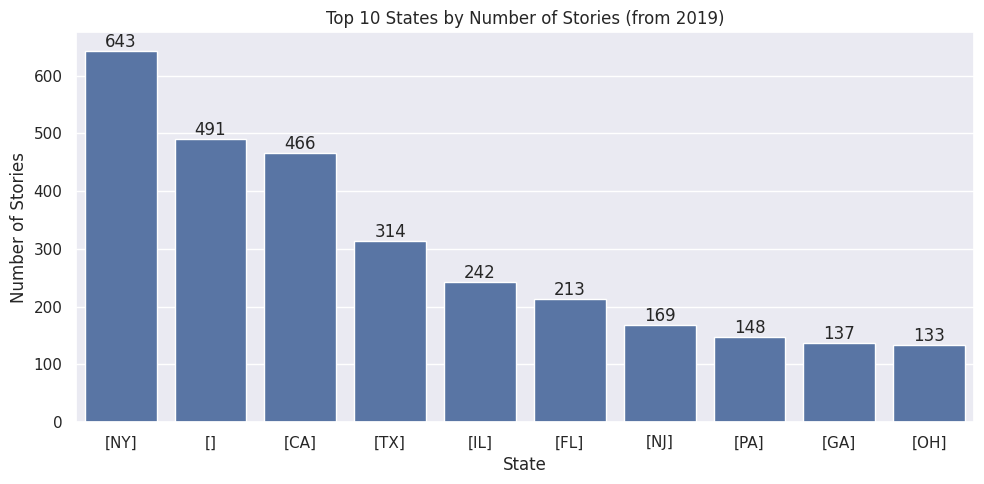

In [42]:
fig = plt.figure(figsize=(10,5), tight_layout=True)
ax = plt.axes()

g = sns.barplot(df_state_story[0:10], 
            x='state', y='count',
           ax=ax)

for i in g.containers:
    ax.bar_label(i,)
    
ax.set_title('Top 10 States by Number of Stories (from 2019)')
ax.set_ylabel('Number of Stories')
ax.set_xlabel('State')

In [43]:
# tpwire[tpwire['state'] == '[]'].iloc[0].loc['summaryplaintext']
# tpwire[tpwire['state'] == '[]']

In [44]:
# tpwire[tpwire['state'] == '[]'].loc[637].loc['summaryplaintext']

#### 2.3 Distribution of number of stories behind NY state

In [45]:
df_city_NY = tpwire[tpwire['state'] == '[NY]']['county'].value_counts().reset_index().sort_values(by='count', ascending=False)

Text(0.5, 0, 'County')

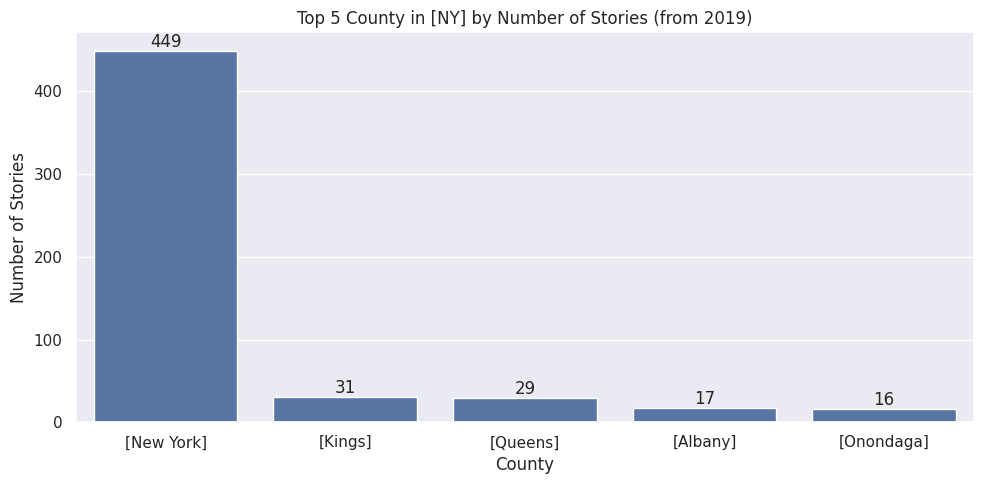

In [46]:
fig = plt.figure(figsize=(10,5), tight_layout=True)
ax = plt.axes()

g = sns.barplot(df_city_NY.head(5), 
            x='county', y='count',
           ax=ax)

for i in g.containers:
    ax.bar_label(i,)
    
ax.set_title('Top 5 County in [NY] by Number of Stories (from 2019)')
ax.set_ylabel('Number of Stories')
ax.set_xlabel('County')

#### 2.4 Distribution of property type of treppwire credit stories

In [47]:
df_type_story = tpwire['proptypecode'].value_counts().reset_index().sort_values(by='count', ascending=False)

In [48]:
df_type_story.head(7)

,proptypecode,count
0,[OF],1707
1,[RT],1176
2,[],487
3,[MF],401
4,[LO],355
5,[MU],234
6,[IN],84


Text(0.5, 1.0, 'Top 7 Property type in Treppwire credit stories (from 2019)')

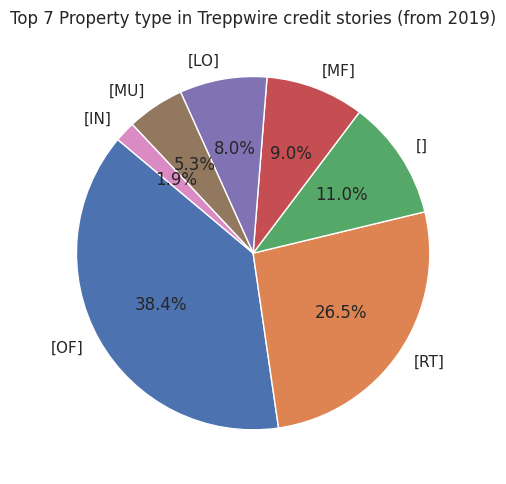

In [49]:
fig = plt.figure(figsize=(5,5), tight_layout=True)
ax = plt.axes()
    
ax.pie(df_type_story.head(7)['count'], labels=df_type_story.head(7)['proptypecode'], autopct='%1.1f%%', startangle=140)

ax.set_title('Top 7 Property type in Treppwire credit stories (from 2019)')

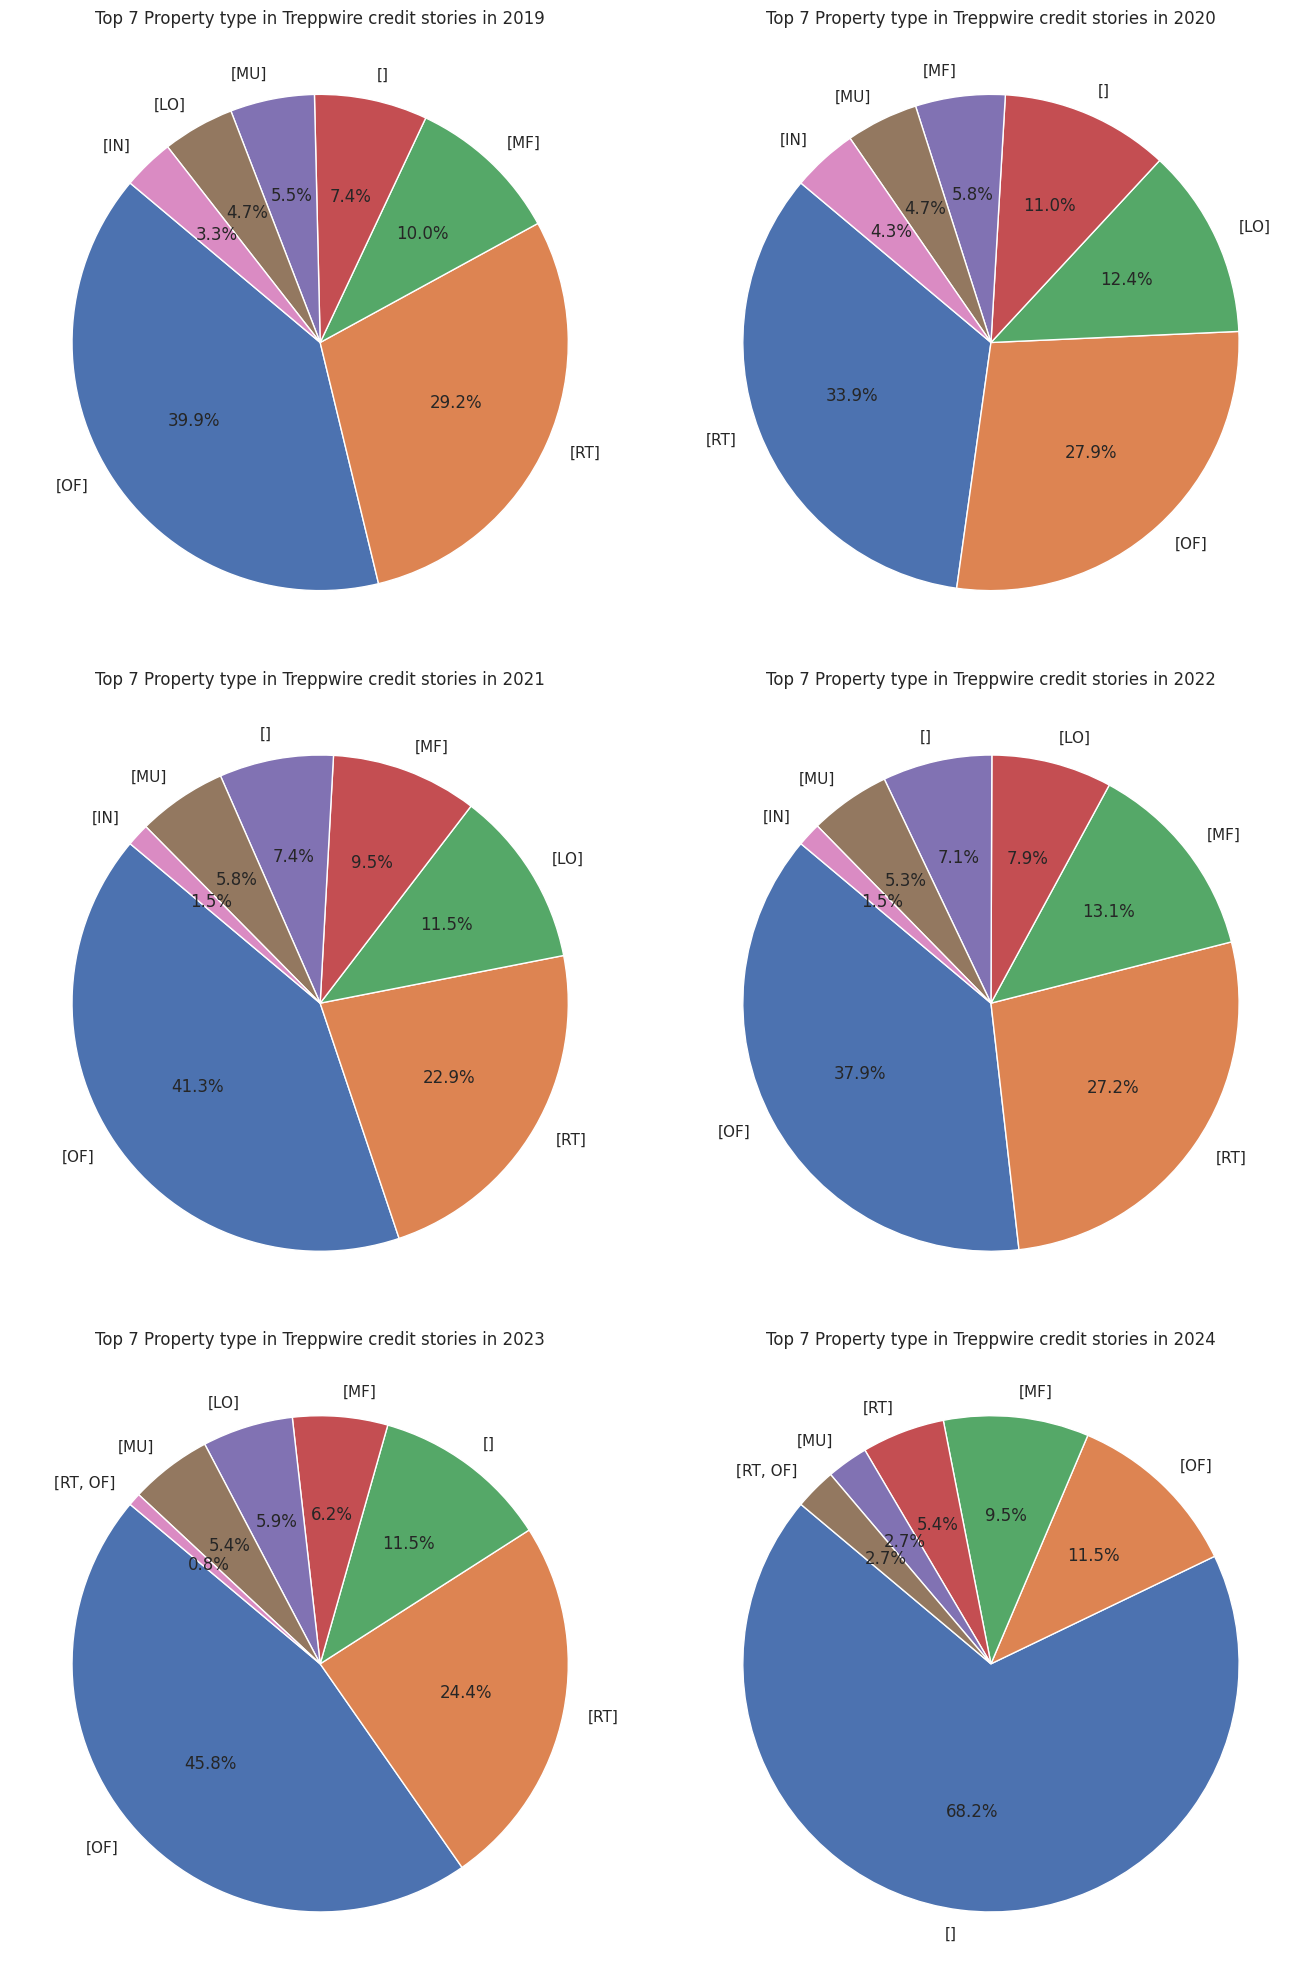

In [50]:
dates = sorted(list(tpwire['publishdate'].dt.year.value_counts().index))
    

fig, ax = plt.subplots(math.ceil(len(dates)/2), 2, figsize=(15,20), tight_layout=True)
ax = ax.flatten()
    
    
for i, date in enumerate(dates):
    data = tpwire[tpwire['publishdate'].dt.year == date]
    data_7 = data['proptypecode'].value_counts().reset_index().sort_values(by='count', ascending=False).head(7)
    ax[i].pie(data_7.head(7)['count'], labels=data_7.head(7)['proptypecode'], autopct='%1.1f%%', startangle=140)

    ax[i].set_title(f'Top 7 Property type in Treppwire credit stories in {date}')

#### 2.5 Number / Average length of Credit storieswritten each year

In [51]:
df_date_story = tpwire['publishdate'].dt.year.value_counts().reset_index().sort_values(by='publishdate')
df_date_story

,publishdate,count
3,2019,760
4,2020,721
2,2021,822
1,2022,987
0,2023,1110
5,2024,148


In [52]:
df = pd.concat([tpwire, pd.DataFrame({'publishyear': tpwire['publishdate'].dt.year})], axis=1)
df_avg_words_year = df.groupby('publishyear').agg(
    avg_word_count = ('summaryplaintext', lambda x: avg_count(x))
).reset_index().sort_values(by='publishyear')
df_avg_words_year

,publishyear,avg_word_count
0,2019,190.160526
1,2020,200.643551
2,2021,172.635036
3,2022,165.759878
4,2023,168.935135
5,2024,223.439189


Text(0.5, 0, 'Year')

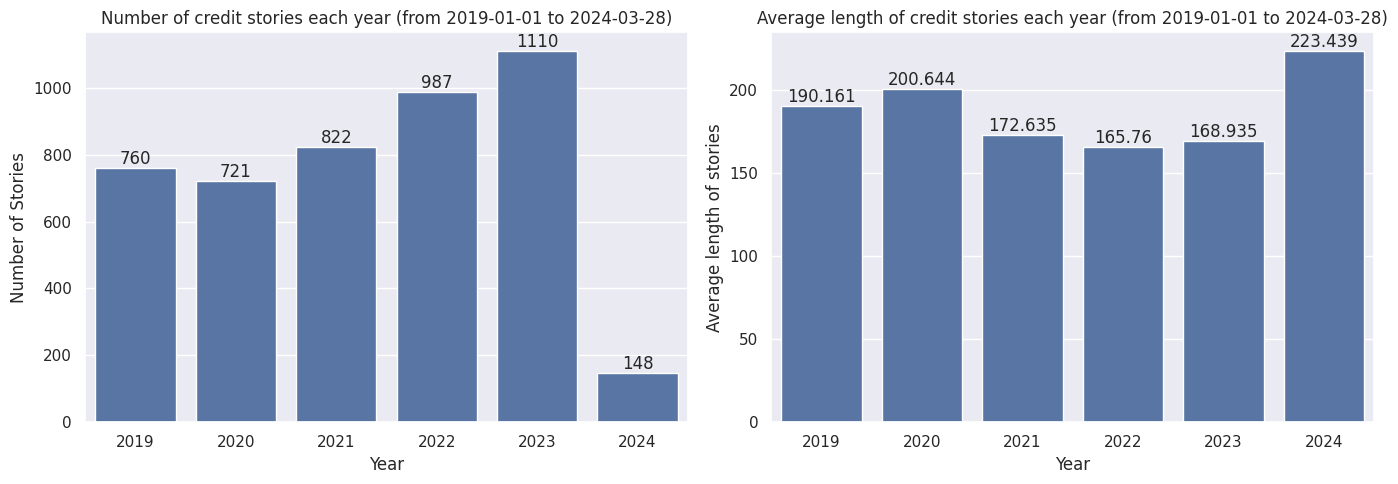

In [56]:
fig, ax = plt.subplots(1, 2, 
                       figsize=(7*2,5), 
                       tight_layout=True)
ax = ax.flatten()
g = sns.barplot(df_date_story, 
            x='publishdate', y='count',
           ax=ax[0])

for i in g.containers:
    ax[0].bar_label(i,)
    
ax[0].set_title('Number of credit stories each year (from 2019-01-01 to 2024-03-28)')
ax[0].set_ylabel('Number of Stories')
ax[0].set_xlabel('Year')


g = sns.barplot(df_avg_words_year, 
            x='publishyear', y='avg_word_count',
           ax=ax[1])

for i in g.containers:
    ax[1].bar_label(i,)
    
ax[1].set_title('Average length of credit stories each year (from 2019-01-01 to 2024-03-28)')
ax[1].set_ylabel('Average length of stories')
ax[1].set_xlabel('Year')

Cut-off date for data

In [54]:
max(tpwire['publishdate'])

Timestamp('2024-07-03 06:30:25')

Last update date for TreppWire data is 2024-03-28 06:30:25

In [55]:
tpwire.head(3)

,creditstoriesid,postid,authoremail,authorname,contentsource,contenttype,dealname,htmlcontent,summaryplaintext,loanid,...,propertysubtype,propsubtypecode,proptypecode,state,county,city,msaname,loanname,region,publishdate
0,14427cb10b9784a45bb56b113786accb92c96202b0361e...,55002,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[BXMT 2020-FL2],"<h4><strong>After Long Wait, Retailer Confirms...","After Long Wait, Retailer Confirms Plan to Vac...",[489884],...,[Urban Office],[Office],[OF],[IL],[Cook],[Chicago],"[Chicago-Naperville-Elgin, IL-IN-WI]",[Old Post Office],[East North Central],2021-08-27 07:53:11
1,02abd2df0ae0b47d49c9595b1f63803ce7fd863af680ba...,53833,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[JPMCC 2010-C2],<h4><strong>Follow-up: Lucky’s Market Bankrupt...,Follow-up: Lucky’s Market Bankruptcy Update – ...,[278029],...,[Urban Office],[Office],[OF],[TX],[Dallas],[Dallas],"[Dallas-Fort Worth-Arlington, TX]",[Bryan Tower],[West South Central],2020-02-05 08:49:56
2,b06de2f945ac8d29a6ed4b612f24a4389c5c1dfe945cdd...,52731,mclancy@trepp.com,Manus Clancy,TreppWire,post,[WABR 2016-BOCA],"<h4><span style=""color: #000000;""><strong>Larg...",Large South Florida Lodging Resort Trades Hand...,[386366],...,[Full Service],[Hotel],[LO],[FL],[Palm Beach],[Boca Raton],"[Miami-Fort Lauderdale-West Palm Beach, FL]",[Waldorf Astoria Boca Raton Resort & Club],[South Atlantic],2019-04-29 08:49:51
